In [110]:
from numpy import ndarray,array, transpose
from carabao.neurotron import Monitor
from carabao.matrix import Attribute, Matrix, Field, rand
from carabao.util import repr

#===============================================================================
# class Map
#===============================================================================

class Map:
    def __init__(self,cluster=None):
        self.cluster = cluster
        self.shape = cluster.shape if cluster is not None else (4,10,2,5)

    def zeros(self,d,s):
        return [[0 for j in range(s)] for i in range(d)]

    def kappa(self,i,j=None):
        """
        self.kappa():  convert matrix indices to linear index or vice versa
        >>> Map().kappa(i:=1,j:=3)   # k = i+j*m
        13
        >>> Map().kappa(k:=13)       # i = k%m, j = k//m
        (1, 3)
        """

        m,n,d,s = self.shape
        if j is None:
            k = i
            return (k%m,k//m)
        else:
            return i + j*m

    def permanence(self,p):    # encode permanence
        """
        self.permanence(p): convert permanence to symbolic string
        >>> o = Map()
        >>> o.permanence(0.52)
        'B'
        >>> o.permanence([-1,0,0.01,0.49,0.5,0.99,1,2])
        '<0yaAY1>'
        """
        def upper(x):
            return chr(int(65+(x-0.5)*100//2))
        def lower(x):
            return chr(int(65+32+(0.5-x)*100//2))

        if isinstance(p,list):
            s = ''
            for k in range(len(p)):
                s += self.permanence(p[k])
            return s

        if p < 0:
            return '<'
        elif p == 0:
            return '0'
        elif p == 1:
            return '1'
        elif p > 1:
            return '>'
        elif p < 0.5:
            return lower(p)
        elif p >= 0.5:
            return upper(p)
        else:
            return '?'

    def symbol(self,x):
        """
        self.symbol(x): convert index to symbol or vice versa
        >>> o = Map()
        >>> o.symbol(11)
        'B'
        >>> o.symbol([0,1,10,11,35,36,37,61,62])
        '01ABZabz062'
        """
        def symb(x):
            if x < 10:
                return chr(48+x)
            if x < 36:
                return chr(55+x)
            elif x < 62:
                return chr(61+x)
            else:
                return '%03g' % x

        if isinstance(x,int):
            return symb(x)
        elif isinstance(x,list):
            s = ''
            for k in range(len(x)):
                s += self.symbol(x[k])
            return s

    def bar(self,n,label='',k=-1):          # bar string of length n
            if n >= 5:
                if k >= 0:
                    str = '%03g' % k
                    if len(label) > 0:
                        str += '/' + label
                else:
                    str = '---'
                while len(str) < n:
                    str += '-'
                    if len(str) < n: str = '-' + str
                return str
            if n >= 3:
                label = '-' + label
            elif n >= 5:
                label = '-' + label
            str = label
            for k in range(n-len(label)): str += '-'
            return str

    def head(self,i,n,s,width=0):
        line = '+'
        s = max(s,width)
        for j in range(n):
            if i < 0:
                sym = ''
                line += self.bar(s,'') + '+'
            else:
                k = self.kappa(i,j)
                sym = self.symbol(k)
                line += self.bar(s,sym,k) + '+'
        return line

    def table(self,kind,I,m,n,width=0,label=''):    # print table
        """
        self.table('i',...) # for indices
        self.table('p',...) # for permanences
        self.table('w',...) # for synaptic weights
        """
        def title(n,x):
            return '-%03g-' % x

        def row(kind,I,i,j,d,s,width):
            str = ''
            for nu in range(s):
               if kind == 'i':   # index
                   str += self.symbol(I[nu])
               elif kind == 'p': # permanence
                   str += self.permanence(I[nu])
               elif kind == 'w': # permanence
                   str += '1' if I[nu] > 0.5 else '0'
               else:
                   str += '?'
            if kind == 's':
                str = I
            while len(str) < width:
                str = str + ' '
                if len(str) < width: str = ' ' + str
            return str

        cells = self.cluster
        d = len(I[0][0])
        s = len(I[0][0][0])

        tab = ''
        for k in range(len(label)): 
            tab += ' '
        
        str = ''
        for i in range(m):
            head = self.head(i,n,s,width)
            trailer = label if i == 0 else tab
            print(trailer+head)
            for mu in range(d):
                line = tab + '|'
                for j in range(n):
                    line += row(kind,I[i][j][mu],i,j,mu,s,width) + '|'
                print(line)
        print(tab+self.head(-1,n,s,width))
   
    def Pmap(self):
        m,n,d,s = cells.shape
        self.table('p',self.cluster.P,m,n,width=max(s,7),label='P: ')

    def Kmap(self):
        m,n,d,s = cells.shape
        self.table('i',self.cluster.K,m,n,width=max(s,7),label='K: ')

    def Gmap(self):
        m,n,d,s = cells.shape
        self.table('i',self.cluster.G,m,n,width=max(s,7),label='G: ')

    def Wmap(self):
        m,n,d,s = cells.shape
        self.table('w',self.cluster.P,m,n,width=max(s,7),label='W: ')

    def Fmap(self):
        m,n,d,s = cells.shape
        self.table('w',self.cluster.F,m,n,width=max(s,7),label='F: ')

    def Smap(self):             # state map
        m,n,d,s = self.shape
        S = self.zeros(m,n)
        cells = self.cluster
        for i in range(m):
            for j in range(n):
                states = ['-','-','-','-','-']
                if cells.U[i,j]: states[0] = 'U'
                if cells.Q[i,j]: states[0] = 'Q'
                if cells.X[i,j]: states[1] = 'X'
                if cells.S[i,j]: states[2] = 'S'
                if cells.L[i,j]: states[2] = 'L'
                if cells.D[i,j]: states[3] = 'D'
                if cells.B[i,j]: states[3] = 'B'
                if cells.Y[i,j]: states[4] = 'Y'
                str = ''
                for k in range(len(states)):
                    str += states[k]
                S[i][j] = [str]
        self.table('s',S,m,n,width=max(s,7),label='S: ')



In [142]:
#=========================================================================
# class Out
#=========================================================================

class Out:
    def __init__(self,cluster,i,j,tag):
        self.cluster = cluster
        self.i = i
        self.j = j
        self.tag = tag

    def out(self):
        data = self.cluster.get(self.tag)
        return data[self.i,self.j]


class Cell(Attribute):
    def __init__(self,cluster,i,j):
        tags = ['u','q','d','b','x','y','s','l']
        for ch in tags:
            self.set(ch,Out(cluster,i,j,ch.upper()))
        #self.set('u',Out(cluster,i,j,'U'))
        #self.u = Out(cluster,i,j,'U')
        #self.q = Out(cluster,i,j,'Q')
        #self.d = Out(cluster,i,j,'D')
        #self.b = Out(cluster,i,j,'B')
        #self.x = Out(cluster,i,j,'X')
        #self.y = Out(cluster,i,j,'Y')
        #self.s = Out(cluster,i,j,'S')
        #self.l = Out(cluster,i,j,'L')
        self.predict = None
        
#=========================================================================
# class Cluster
#=========================================================================

class Cluster(Attribute):
    verbose = 0
    def __init__(self,m=4,n=10,d=2,s=5,f=7):
        self.shape = (m,n,d,s)
        self.sizes = (f,n*m)
        self.eta = 0.5
        self.theta = 3
        self.delta = (0.1,0.1)
        
        self.P = self.tensor(m,n,d,s)     # prediction permanences
        self.K = self.tensor(m,n,d,s)     # prediction indices
        self.P = self.tensor(m,n,d,s)     # prediction permanences
        self.I = self.tensor(m,n,d,s)     # learning increment
        self.F = self.tensor(m,n,1,f)     # excitation weights
        self.G = self.tensor(m,n,1,m-1)   # collaboration weights
        
        self.U = Matrix(m,n)
        self.Q = Matrix(m,n)
        self.D = Matrix(m,n)
        self.B = Matrix(m,n)
        self.X = Matrix(m,n)
        self.Y = Matrix(m,n)
        self.S = Matrix(m,n)
        self.L = Matrix(m,n)

    def zeros(self,d,s):
        return [[0 for j in range(s)] for i in range(d)]
    
    def tensor(self,m,n,d,s):
        return [[self.zeros(d,s) for j in range(n)] for i in range(m)]
            
    def kappa(self,i,j=None):
        """
        self.kappa():  convert matrix indices to linear index or vice versa
        >>> o = Cluster(m=4,n=10)
        >>> k = o.kappa(i:=1,j:=3)  # k = i+j*m 
        13
        >>> ij = o.kappa(k:=13)    # i = k%m, j = k//m
        (1,3)
        """

        m,n,d,s = self.shape
        if j is None:
            k = i
            return (k%m,k//m)
        else:
            return i + j*m

    def setP(self,i,j,P):
        assert isinstance(P,list) and isinstance(P[0],list) 
        self.P[i][j] = P.copy()

    def setK(self,i,j,K):
        assert isinstance(K,list) and isinstance(K[0],list) 
        self.K[i][j] = K.copy()

    def setG(self,i,j,G):
        assert isinstance(G,list) and isinstance(G[0],list) 
        self.G[i][j] = G.copy()
    
    def initG(self):
        m,n,d,s = self.shape
        for i in range(m):
            for j in range(n):
                g = []
                for nu in range(m):
                    k = self.kappa(nu,j)
                    if nu != i: g.append(k)
                self.setG(i,j,[g])

    def initK(self):
        #rg = Random(seed=0)             # create random generator
        m,n,d,s = self.shape
        N = m*n
        for i in range(m):
            for j in range(n):
                K = self.zeros(d,s)
                for mu in range(d):
                    for nu in range(s):
                        K[mu][nu] = rand(N)
                self.setK(i,j,K)

    def initP(self):
        m,n,d,s = self.shape
        Q = 20                          # quantizing constant
        for i in range(m):
            for j in range(n):
                P = self.zeros(d,s)
                for mu in range(d):
                    for nu in range(s):
                        P[mu][nu] = (1/Q + rand(Q))
                self.setP(i,j,P)

    def initF(self,f=(7,4)):            # init pooler
        m,n,d,s = self.shape
        ft,fs = f                       # ft: total bits, fs: sparse bits
        self.F = self.tensor(m,n,1,ft)  # excitation weights
        tokens = {}
        for j in range(n):
            while True:
                w = [0 for k in range(ft)]
                for k in range(fs):
                    w[rand(ft)] = 1
                if sum(w) == fs:
                    key = ''
                    for k in range(ft):
                        key += '1' if w[k] else '0'
                    if key in tokens:
                        continue
                    tokens[key] = True
                    break
            for i in range(m):        
                self.F[i][j][0] = w

    def init(self):
        self.initP()
        self.initK()
        self.initG()
        self.initF()
        return self

    def map(self):
        Map(cells).Kmap()
        Map(cells).Pmap()
        Map(cells).Wmap()
        Map(cells).Gmap()

    def stimu(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                e = (array(self.F[i][j][0])*array(f))
                self.U[i,j] = int(e.sum() >= 3)
                #print('U[%g,%g]:' % (i,j),self.U[i][j])
        return y

    def react(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                self.Y[i,j] = self.U[i,j] * self.X[i,j]
                k = self.kappa(i,j)
                y[k] = self.Y[i,j]
                self.L[i,j] = self.X[i,j] * self.Y[i,j]
                if self.L[i,j]:
                    _Pij = array(self.P[i][j])
                    for mu in range(d):
                        for nu in range(s):
                            self.P[i][j][mu][nu] += self.I[i][j][mu][nu] 
                            self.P[i][j][mu][nu] = max(0,min(1,self.P[i][j][mu][nu]))
                    Pij = array(self.P[i][j])
                    if self.verbose > 0:
                        print('learn P[%g,%g]:' % (i,j),repr(_Pij),'=>',repr(Pij))
        return y

    def depress(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                g = self.G[i][j][0]
                v = g.copy()
                for nu in range(len(g)):
                    k = g[nu]
                    v[nu] = c[k]   
                e = array(v)
                self.D[i,j] = int(e.sum() > 0)
                self.L[i,j] = 0
                #print('D[%g,%g]:' % (i,j),self.D[i][j])
        return y

    def excite(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                self.Q[i,j] = self.U[i,j]
        return y

    def burst(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                self.B[i,j] = int(not self.D[i,j] and self.Q[i,j])
                self.Y[i,j] = int(self.Y[i,j] or self.B[i,j])
                k = self.kappa(i,j)
                y[k] = self.Y[i,j]
        return y

    def predict(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                K = self.K[i][j]
                P = self.P[i][j]
                V = array(self.zeros(d,s))
                W = array(self.zeros(d,s))
                E = array(self.zeros(d,s))
                for mu in range(d):
                    for nu in range(s):
                        k = K[mu][nu]
                        V[mu][nu] = c[k]
                        W[mu][nu] = int(P[mu][nu] >= 0.5)
                        E[mu][nu] = V[mu][nu] * W[mu][nu]
                spike = [0 for mu in range(d)]
                for mu in range(d):
                    spike[mu] = int(sum(E[mu]) >= self.theta)
                self.S[i,j] = array(spike).max()
                #print('V:',V,'W:',W,'E:',E,'spike:',spike)
                self.X[i,j] = self.S[i,j]
                if self.S[i,j]:
                    pdelta,ndelta = self.delta
                    for mu in range(d):
                        for nu in range(s):
                            self.I[i][j][mu][nu] = spike[mu]*(2*pdelta*V[mu][nu] - ndelta)
        return y

    def relax(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                self.U[i,j] = 0
                self.Q[i,j] = 0
                self.D[i,j] = 0
                self.B[i,j] = 0
                self.Y[i,j] = 0
                self.S[i,j] = 0
                k = self.kappa(i,j)
                y[k] = self.Y[i,j]
        return y

    def idle(self):
        m,n,d,s = self.shape
        for i in range(m):
            for j in range(n):
                self.U[i,j] = 0
                self.Q[i,j] = 0
                self.D[i,j] = 0
                self.B[i,j] = 0
                self.Y[i,j] = 0
                self.S[i,j] = 0
                self.X[i,j] = 0
                self.L[i,j] = 0
                k = self.kappa(i,j)
                y[k] = self.Y[i,j]
        return y
        

    def plot(self,mon,subplot=0,title=None):
        m,n,d,s = self.shape
        for i in range(m):
            for j in range(n):
                cell = Cell(self,i,j)
                mon(cell,i+subplot*(m+1),j)
        if title is not None:
            mon.title(title)

    def apply(self,y,tag='',log=None,all=None):
        m,n,d,s = self.shape
        y = self.stimu(y);
        prefix = tag + ' - ' if tag != '' else ''
        if log is not None:
            print('stimu ...');  Map(cells).Smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'stimu')

        y = self.react(y);
        if log is not None:
            print('ract ...');  Map(cells).Smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'react')
        else:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'react')
        
        y = cells.depress(y);
        if log is not None:
            print('depress ...');  Map(cells).Smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'depress')
        
        y = cells.excite(y);
        if log is not None:
            print('excite ...');   Map(cells).Smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'excite')

        y = cells.burst(y);
        if log is not None:
            print('burst ...');    Map(cells).Smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'burst')
        
        y = cells.predict(y);  
        if log is not None:
            print('predict ...');  Map(cells).Smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'predict')
        else:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'predict')
        
        y = cells.relax(y);
        if log is not None:
            print('relax ...');    Map(cells).Smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'relax')
        return y        

#==========================================================================================================
# tokenizer
#==========================================================================================================


token = {'Mary': [1,0,1,1,0,1,0,1],
         'John': [1,1,0,0,1,0,1,1],
         'likes':[0,1,1,0,1,0,1,1],
         'to':   [1,1,0,1,0,0,1,1],
         'sing': [0,1,0,0,1,1,1,1],
         'dance':[0,0,1,1,0,1,1,1],
         '.':    [0,1,1,0,1,1,1,0],
        }


F:
 [[[[1, 1, 0, 0, 1, 0, 1]], [[0, 1, 1, 0, 1, 1, 0]], [[1, 1, 0, 0, 1, 1, 0]], [[0, 0, 1, 1, 0, 1, 1]], [[0, 1, 1, 1, 0, 0, 1]], [[1, 1, 1, 1, 0, 0, 0]], [[0, 0, 1, 0, 1, 1, 1]], [[1, 0, 1, 1, 1, 0, 0]], [[1, 0, 1, 0, 1, 1, 0]], [[1, 0, 1, 0, 1, 0, 1]]], [[[1, 1, 0, 0, 1, 0, 1]], [[0, 1, 1, 0, 1, 1, 0]], [[1, 1, 0, 0, 1, 1, 0]], [[0, 0, 1, 1, 0, 1, 1]], [[0, 1, 1, 1, 0, 0, 1]], [[1, 1, 1, 1, 0, 0, 0]], [[0, 0, 1, 0, 1, 1, 1]], [[1, 0, 1, 1, 1, 0, 0]], [[1, 0, 1, 0, 1, 1, 0]], [[1, 0, 1, 0, 1, 0, 1]]], [[[1, 1, 0, 0, 1, 0, 1]], [[0, 1, 1, 0, 1, 1, 0]], [[1, 1, 0, 0, 1, 1, 0]], [[0, 0, 1, 1, 0, 1, 1]], [[0, 1, 1, 1, 0, 0, 1]], [[1, 1, 1, 1, 0, 0, 0]], [[0, 0, 1, 0, 1, 1, 1]], [[1, 0, 1, 1, 1, 0, 0]], [[1, 0, 1, 0, 1, 1, 0]], [[1, 0, 1, 0, 1, 0, 1]]], [[[1, 1, 0, 0, 1, 0, 1]], [[0, 1, 1, 0, 1, 1, 0]], [[1, 1, 0, 0, 1, 1, 0]], [[0, 0, 1, 1, 0, 1, 1]], [[0, 1, 1, 1, 0, 0, 1]], [[1, 1, 1, 1, 0, 0, 0]], [[0, 0, 1, 0, 1, 1, 1]], [[1, 0, 1, 1, 1, 0, 0]], [[1, 0, 1, 0, 1, 1, 0]], [[1, 0, 1, 0,

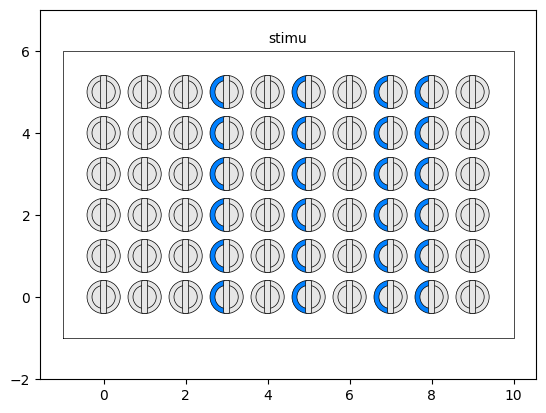

In [143]:
class Cells(Cluster):
    def states(self):
        """
        cells = Cells()
        U = cells.states()
        """
        return (self.U)
        
    def params(self):
        """
        cells = Cells()
        F = cells.params()
        """
        return (self.F)

    def stimu(self,y):
        def trn(list):
            return transpose(array([list]))
        """
        e = F @ f'
        """
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        U = self.states();  F = self.params()
        
        fT = trn(f);
        print("F:\n",F,"f':",fT)
        
        for i in range(m):
            for j in range(n):
                e = (array(F[i][j][0])*array(f))
                U[i,j] = int(e.sum() >= 3)
                #print('U[%g,%g]:' % (i,j),self.U[i][j])
        return y

m=6; n = 10
cells = Cells(m,n,2,5).init()
c=[0 for k in range(m*n)]; f = token['Mary']; y = c + f
y = cells.stimu(y)
Map(cells).Smap(); mon=Monitor(m,n); cells.plot(mon,title='stimu')

In [144]:
m=6; n = 10
cells = Cluster(m,n,2,5).init()
#cells.map()
#Map(cells).Fmap()
#Map(cells).Smap()


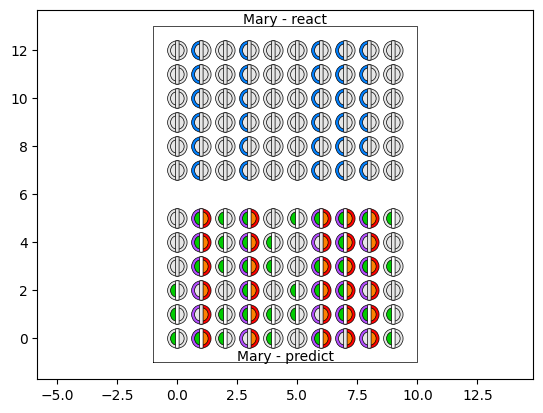

In [145]:

cells = Cluster(m,n,2,5).init()
c=[0 for k in range(m*n)]; f = token['Mary']; y = c + f
y = cells.apply(y,'Mary')


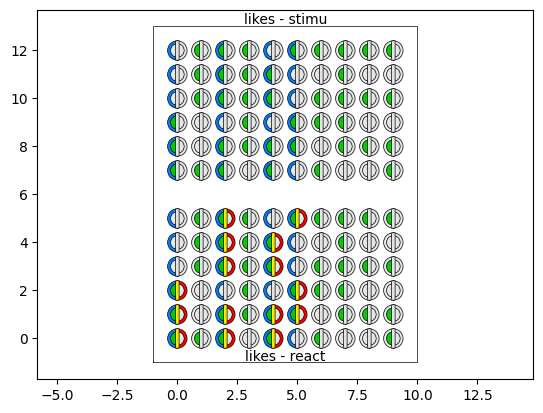

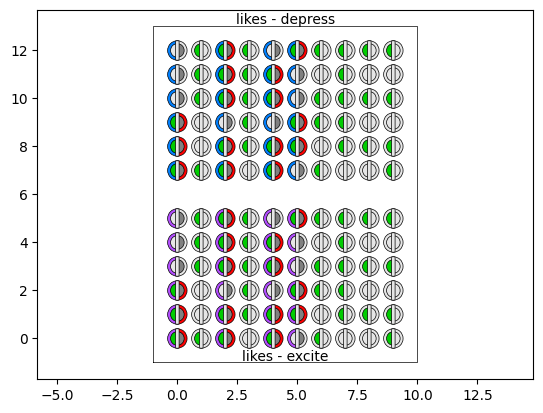

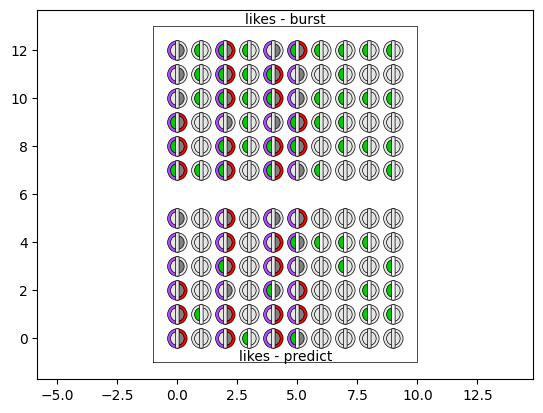

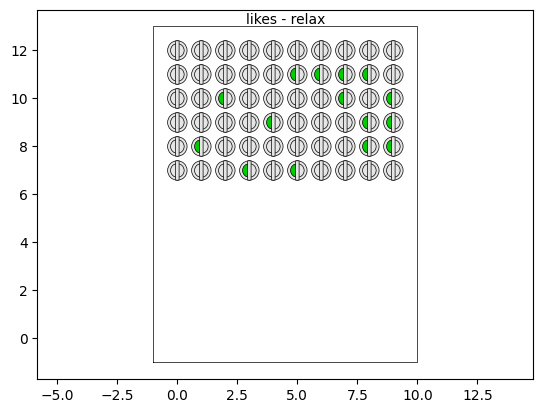

In [146]:
c=[0 for k in range(m*n)]; f = token['likes']; y = c + f
y = cells.apply(y,'likes',all=True)



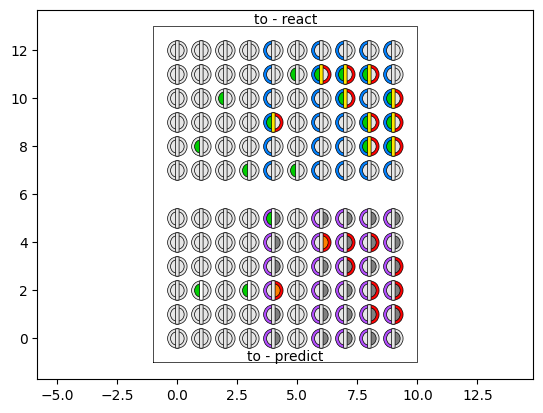

In [147]:
c=[0 for k in range(m*n)]; f = token['to']; y = c + f
y = cells.apply(y,'to')


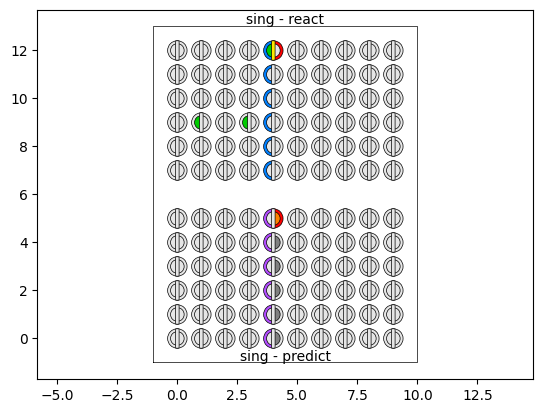

In [148]:
c=[0 for k in range(m*n)]; f = token['sing']; y = c + f
y = cells.apply(y,'sing')


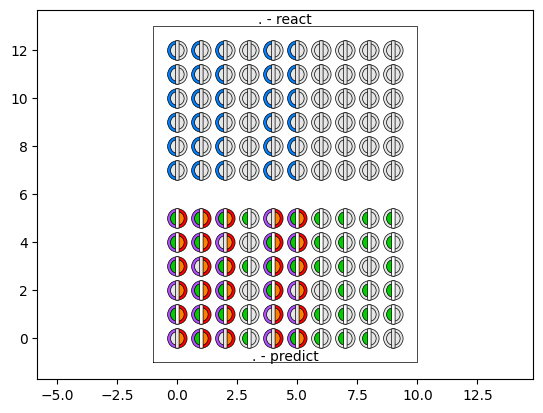

In [149]:
c=[0 for k in range(m*n)]; f = token['.']; y = c + f
y = cells.apply(y,'.')

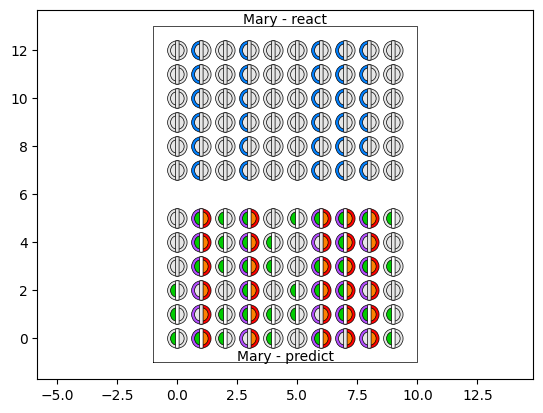

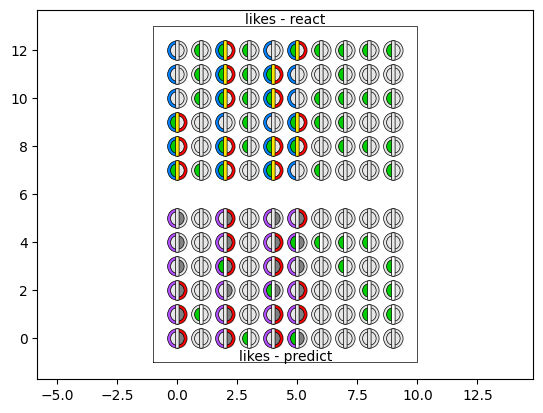

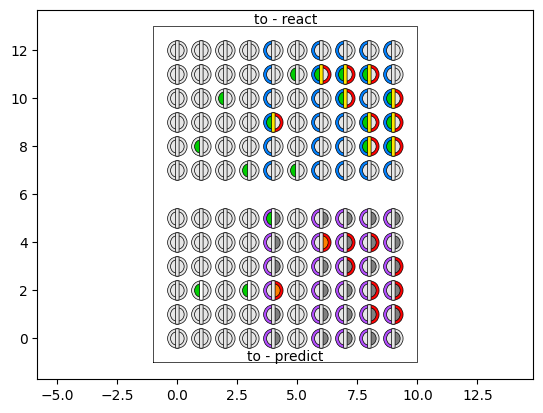

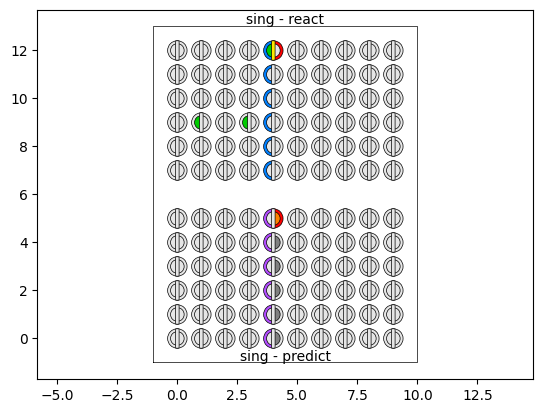

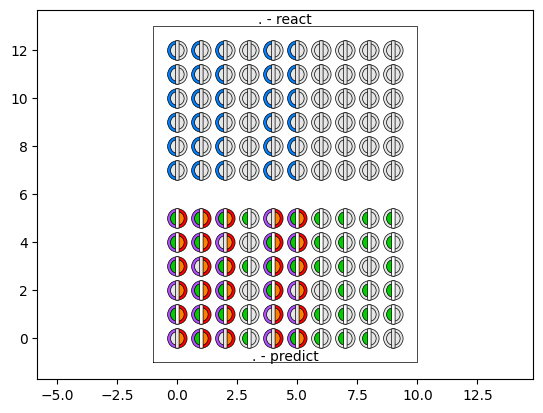

In [150]:
seq = ['Mary','likes','to','sing','.']
cells.idle()
for word in seq:
    c=[0 for k in range(m*n)]; f = token[word]; y = c + f
    y = cells.apply(y,word)